In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mczielinski/bitcoin-historical-data")

print("Path to dataset file:", path)

Path to dataset file: /kaggle/input/bitcoin-historical-data


In [3]:
df = pd.read_csv(f"{path}/btcusd_1-min_data.csv")
df["Timestamp"] = pd.to_datetime(df["Timestamp"], unit="s", utc=True)

df = df.sort_values("Timestamp").tail(1500) # Past one day

In [4]:
df["Return"] = np.log(df["Close"].shift(1) / df["Close"])

In [5]:
df.head()

,Timestamp,Open,High,Low,Close,Volume,Return
7098868,2025-07-01 23:49:00+00:00,105596.0,105630.0,105596.0,105630.0,0.014916,NaN
7098869,2025-07-01 23:50:00+00:00,105630.0,105630.0,105619.0,105619.0,0.032575,0.000104
7098870,2025-07-01 23:51:00+00:00,105619.0,105619.0,105619.0,105619.0,0.018414,0.000000
7098871,2025-07-01 23:52:00+00:00,105620.0,105620.0,105620.0,105620.0,0.020000,-0.000009
7098872,2025-07-01 23:53:00+00:00,105620.0,105627.0,105620.0,105621.0,0.110381,-0.000009


In [6]:
returns = df["Return"].values
LOOKBACK = 60
X = []
for i in range(1+LOOKBACK, len(returns)):
    X.append(returns[i - LOOKBACK : i])
X = np.array(X , dtype=np.float32)
X = X[..., np.newaxis]
preds = []

In [7]:
model = tf.keras.models.load_model('model_0.keras', compile=False)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 60, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 60, 128)        │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_1             │ (None, 60, 128)        │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 96)             │         6,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 48)             │         4,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           147 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 61,475 (240.14 KB)

 Trainable params: 61,475 (240.14 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
X.shape

(1439, 60, 1)

In [9]:
model.input_shape

(None, 60, 1)

In [10]:
probs = model.predict(X, batch_size=1024, verbose=0)

In [11]:
probs.shape

(1439, 3)

Probability for movement : DOWN / CONSTANT / RISE

In [12]:
df2 = pd.DataFrame(probs, columns=['p_sell', 'p_hold', 'p_buy'])
df2['Price'] = df['Close'].iloc[1+LOOKBACK:].reset_index(drop=True)
df2['Timestamp'] = df['Timestamp'].iloc[1+LOOKBACK:].reset_index(drop=True)

Risk_apetite = 0.70

def classify(row):
    if row.p_buy >= Risk_apetite:
        return 1
    elif row.p_sell >= Risk_apetite:
        return -1
    return 0

df2['pred'] = df2.apply(classify, axis=1)

t1 = df2['Timestamp'].max() - pd.Timedelta(minutes=120)
t2 = df2['Timestamp'].max() - pd.Timedelta(minutes=360)
plot_df = df2[(df2['Timestamp'] >= t2) & (df2['Timestamp'] <= t1)].reset_index(drop=True)

In [13]:
plot_df.head()

,p_sell,p_hold,p_buy,Price,Timestamp,pred
0,0.039139,0.940849,0.020012,109501.0,2025-07-02 18:48:00+00:00,0
1,0.219066,0.774074,0.006859,109470.0,2025-07-02 18:49:00+00:00,0
2,0.143426,0.846989,0.009585,109451.0,2025-07-02 18:50:00+00:00,0
3,0.119258,0.870711,0.010031,109476.0,2025-07-02 18:51:00+00:00,0
4,0.093111,0.895448,0.011441,109498.0,2025-07-02 18:52:00+00:00,0


In [14]:
buy = plot_df[plot_df['pred'] == 1]
sell = plot_df[plot_df['pred'] == -1]
hold = plot_df[plot_df['pred'] == 0]

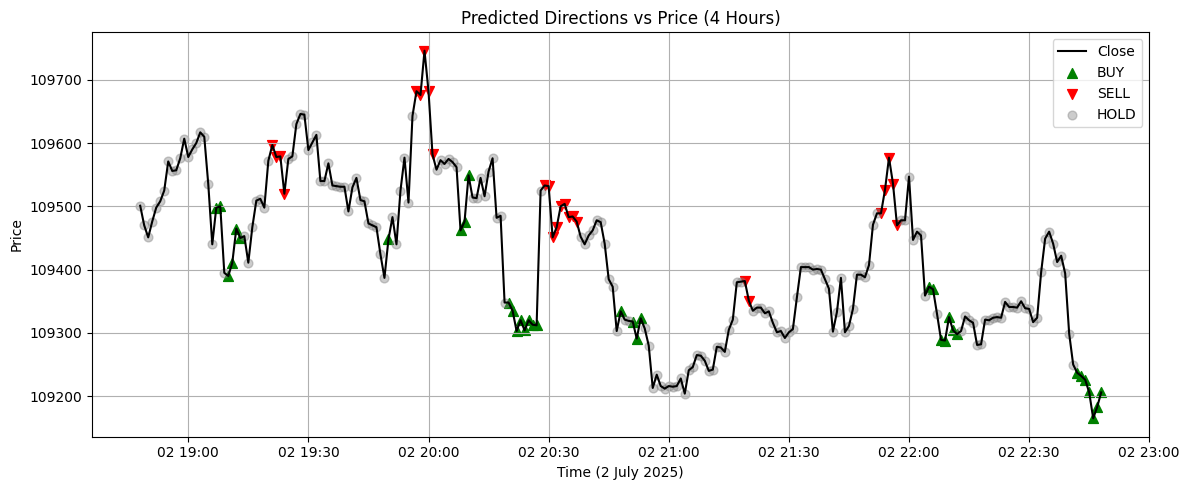

In [15]:
plt.figure(figsize=(12, 5))
plt.plot(plot_df['Timestamp'], plot_df['Price'], color='black', label='Close')
plt.scatter(buy['Timestamp'], buy['Price'], color='green', marker='^', s=50, label='BUY')
plt.scatter(sell['Timestamp'], sell['Price'], color='red', marker='v', s=50, label='SELL')
plt.scatter(hold['Timestamp'], hold['Price'], color='gray', marker='o', s=40, alpha=0.4, label='HOLD')
plt.title("Predicted Directions vs Price (4 Hours)")
plt.xlabel("Time (2 July 2025)")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

The red arrows indicate model suggesting to sell and the green arrows indicate the model suggesting to buy.

This help in decision making would significantly increase the capture by market micro movements